In [1]:
import denoising
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage.transform import rescale
from utils import mode
from utils import kmeans_vq
from utils import discretise
from skimage.measure import compare_mse

/home/redzin/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


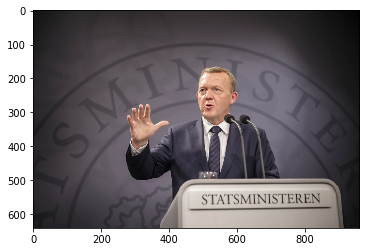

In [2]:
# Load the image
img = rescale(plt.imread('data/lars.jpg'), 1.0)
img = skimage.img_as_float(img)
plt.imshow(img, cmap="gray")
plt.show()

In [3]:
# Settings
colours_bins = 10
n_iter = 80
samples = 100
map_iter = 80
t0 = 4
diffusion = 0.995
beta = 5
speckle_var = 0.02

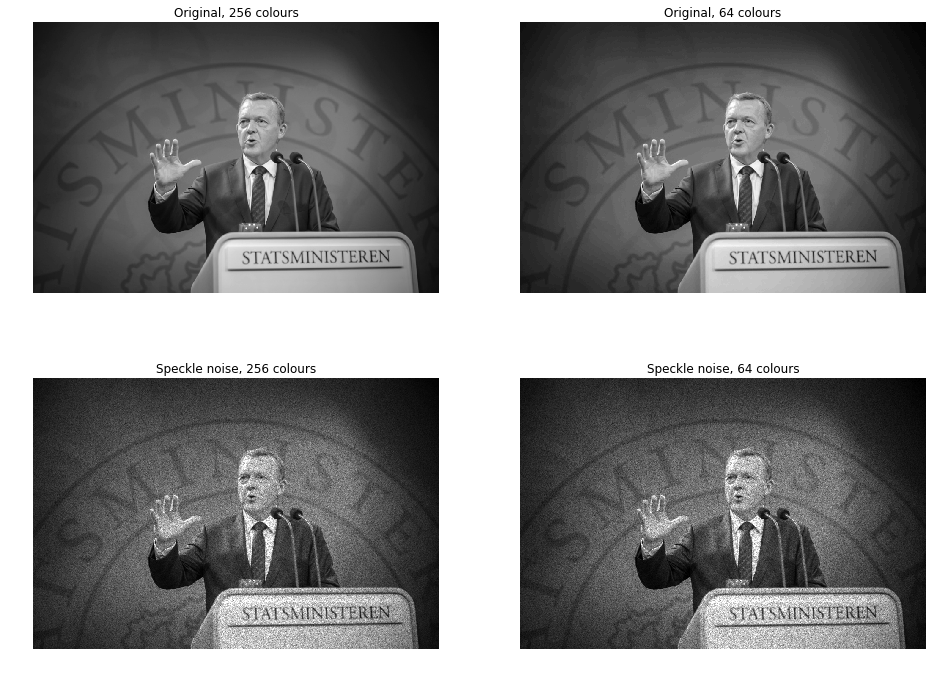

In [4]:
# Image pre-processing (degradation, etc.)
X = np.mean(img, 2)
Y = skimage.util.random_noise(X, 'speckle', mean=0, var=speckle_var)
Y_disc = discretise(Y, colours_bins)
X_disc = discretise(X, colours_bins)

fig, axarr = plt.subplots(2, 2, figsize=(16,12))

axarr[0,0].imshow(X, cmap='gray')
axarr[0,0].grid(False)
axarr[0,0].axis('off')
axarr[0,0].set_title("Original, 256 colours")

axarr[0,1].imshow(X_disc, cmap='gray')
axarr[0,1].grid(False)
axarr[0,1].axis('off')
axarr[0,1].set_title("Original, " +str(colours_bins) + " colours")

axarr[1,0].imshow(Y, cmap='gray')
axarr[1,0].grid(False)
axarr[1,0].axis('off')
axarr[1,0].set_title("Speckle noise, 256 colours")

axarr[1,1].imshow(Y_disc, cmap='gray')
axarr[1,1].grid(False)
axarr[1,1].axis('off')
axarr[1,1].set_title("Speckle noise, " +str(colours_bins) + " colours")

plt.savefig("results/base_preprocessing", bbox_inches='tight')
plt.show()


In [5]:
pottsobj = denoising.PottsMH(Y, beta=beta, sigma=Y.std(), bins = colours_bins)

In [ ]:
%time X_samples = [pottsobj.metropolisHastings2(n_iter, Y_disc) for i in range(samples)]

In [44]:
%time X_map = np.array(pottsobj.MAP2(80, Y_disc, tInit=t0, diffusion=diffusion))

CPU times: user 13.4 s, sys: 44 ms, total: 13.5 s
Wall time: 13.4 s


In [ ]:
X_mean = np.mean(X_samples, 0)
X_mode = mode(X_samples, 0)

In [ ]:
fig, axarr = plt.subplots(2,2, figsize=(16,12))

axarr[0,0].imshow(X_disc, cmap='gray')
axarr[0,0].grid(False)
axarr[0,0].axis('off')
axarr[0,0].set_title("Original Image")

axarr[0,1].imshow(Y_disc, cmap='gray')
axarr[0,1].grid(False)
axarr[0,1].axis('off')
axarr[0,1].set_title("Noisy Image, MSE = %.4f" % compare_mse(X, Y_disc))

axarr[1,0].imshow(X_mean, cmap='gray')
axarr[1,0].grid(False)
axarr[1,0].axis('off')
axarr[1,0].set_title("Mean Estimate, MSE = %.4f" % compare_mse(X, X_mean))

axarr[1,1].imshow(X_mode, cmap='gray')
axarr[1,1].grid(False)
axarr[1,1].axis('off')
axarr[1,1].set_title("MPM Estimate, MSE = %.4f" % compare_mse(X, X_mode))

#axarr[1,1].imshow(X_map, cmap='gray')
#axarr[1,1].grid(False)
#axarr[1,1].axis('off')
#axarr[1,1].set_title("MAP Estimate, MSE = %.4f" % compare_mse(X, X_map))

plt.savefig("results/base_comparison", bbox_inches='tight')
plt.show()
